# Project Name

---

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)


## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

### 2.2. Importing the Data: <a name="dataimport"></a>

In [3]:
# Set directories
current_wdir = os.getcwd()
data_folder_hourly = current_wdir + '/Data/Hourly_Load'
data_folder_gen = current_wdir + '/Data/Gen_by_Fuel'

## 3. Data Preprocessing <a name="datapre"></a>

---

In [4]:
file_path_load = [f'{data_folder_hourly}/{file}' for file in os.listdir(data_folder_hourly) if '.csv' in file]
file_path_load = sorted(file_path_load)

file_path_gen = [f'{data_folder_gen}/{file}' for file in os.listdir(data_folder_gen) if '.csv' in file]
file_path_gen = sorted(file_path_gen)

# pd.read_csv can unzip as it goes with compression argument.
load_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_load], join = 'outer', ignore_index = False, axis = 0)
gen_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_gen], join = 'outer', ignore_index = False, axis = 0)

In [5]:
display(load_df)
display(load_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,BC,BC,2358.000,True
1,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,AE,855.000,True
2,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,DPL,1150.000,True
3,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,JC,1632.000,True
4,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,ME,929.000,True
...,...,...,...,...,...,...,...,...
62605,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,RECO,RECO,131.877,False
62606,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PEP,SMECO,355.931,False
62607,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PL,UGI,101.478,True
62608,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,AE,VMEU,70.051,False


datetime_beginning_utc     object
datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
is_verified                  bool
dtype: object

In [6]:
display(gen_df)
display(gen_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Coal,34820,0.41,False
1,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Gas,11169,0.13,False
2,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Hydro,699,0.01,True
3,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Multiple Fuels,266,0.00,False
4,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Nuclear,34269,0.41,False
...,...,...,...,...,...,...
21095,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Oil,221,0.00,False
21096,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Other Renewables,690,0.01,True
21097,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Solar,12,0.00,True
21098,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Storage,0,0.00,False


datetime_beginning_utc       object
datetime_beginning_ept       object
fuel_type                    object
mw                            int64
fuel_percentage_of_total    float64
is_renewable                   bool
dtype: object

In [7]:
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
load_df[date_cols] = load_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
gen_df[date_cols] = gen_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)

In [8]:
sorted(load_df['zone'].unique())

['AE',
 'AEP',
 'AP',
 'ATSI',
 'BC',
 'CE',
 'CNCT',
 'DAY',
 'DEOK',
 'DOM',
 'DPL',
 'DUQ',
 'EKPC',
 'GPU',
 'JC',
 'ME',
 'OVEC',
 'PE',
 'PEP',
 'PL',
 'PN',
 'PS',
 'RECO',
 'RTO']

In [9]:
load_zone_df = load_df[['datetime_beginning_ept', 'zone', 'mw']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum()

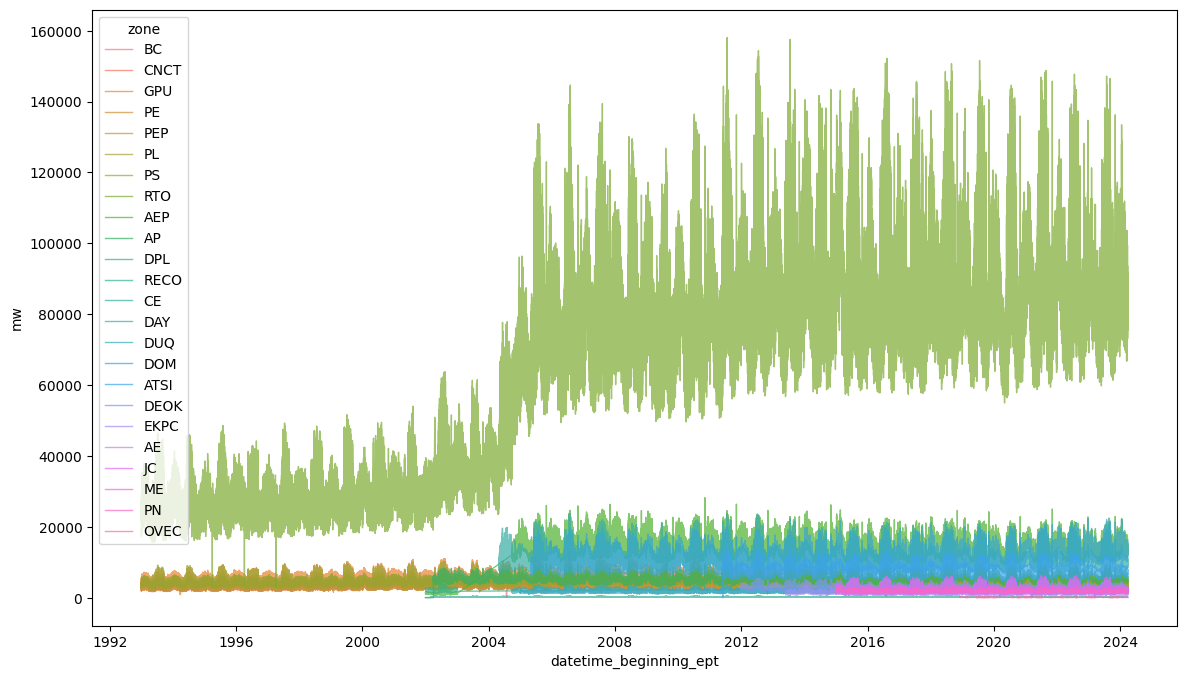

In [10]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

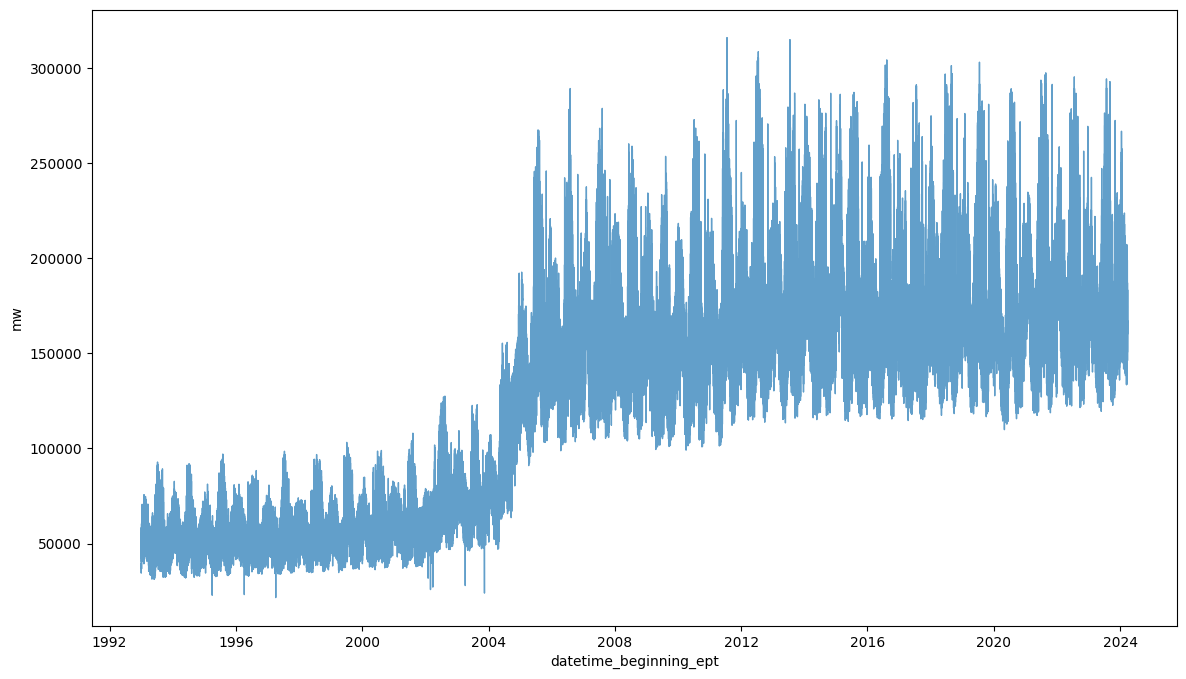

In [11]:

ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), 
                  x = 'datetime_beginning_ept', 
                  y = 'mw',  
                  alpha = 0.7, lw = 1)

In [12]:
gen_fuel_df = gen_df[['datetime_beginning_ept', 'fuel_type', 'mw']].groupby(['datetime_beginning_ept', 'fuel_type'], as_index = False).sum()

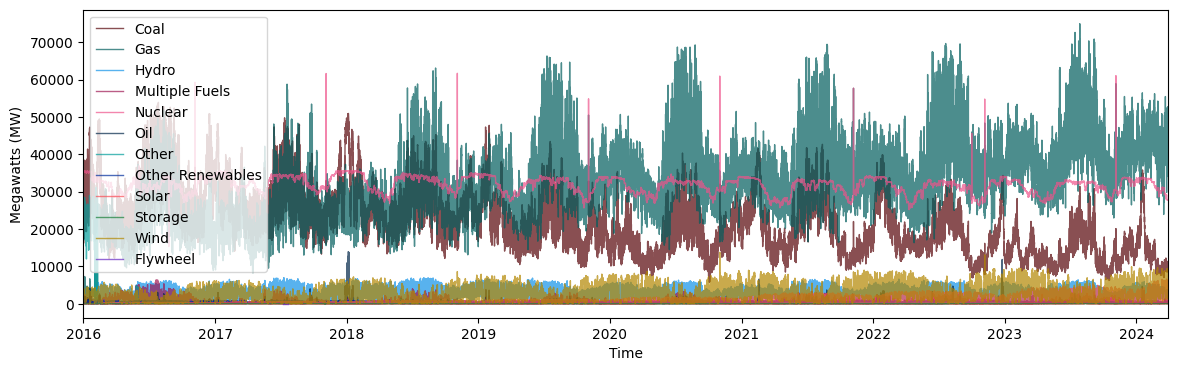

In [13]:
palette = ['#570408', '#005d5d', '#1192e8', '#9f1853', '#ee538b', '#012749', '#009d9a', '#002d9c', '#fa4d56', '#198038', '#b28600', '#6929c4']

ax, fig = plt.subplots(figsize = (14, 4))
ax = sns.lineplot(gen_fuel_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'fuel_type', alpha = 0.7, lw = 1, palette = sns.color_palette(palette, 12))
ax.margins(x = 0)
ax.set_xlabel('Time')
ax.set_ylabel('Megawatts (MW)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)
plt.legend(loc = 'upper left')
plt.show()

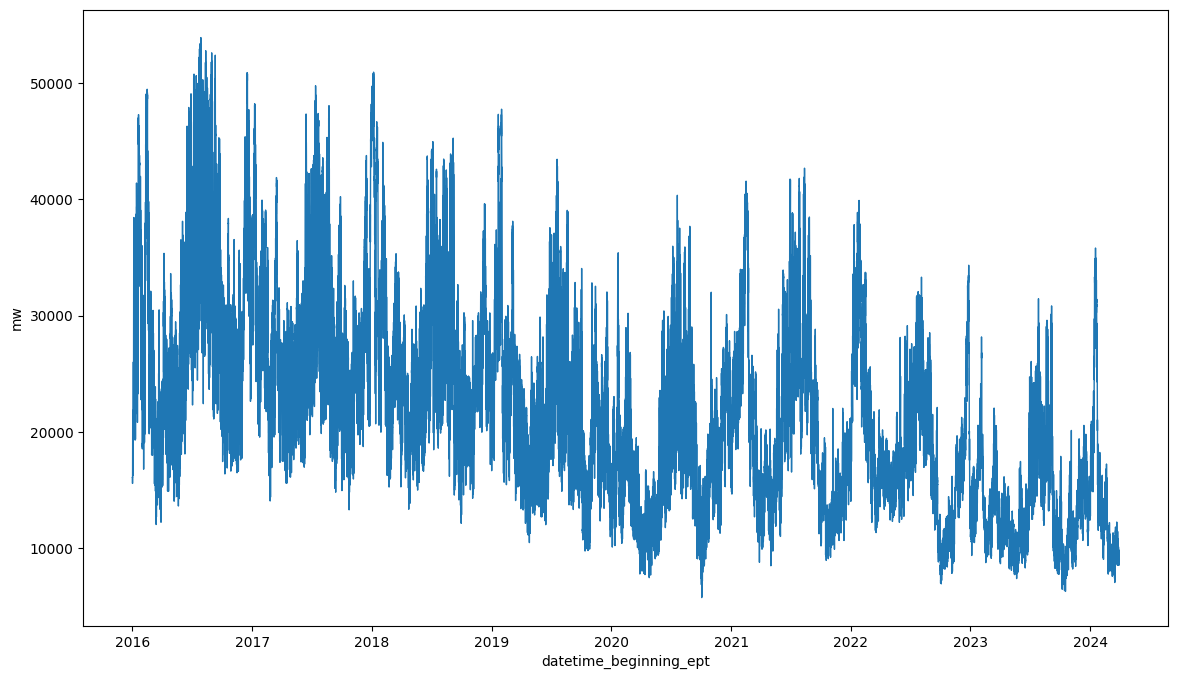

In [14]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Coal'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

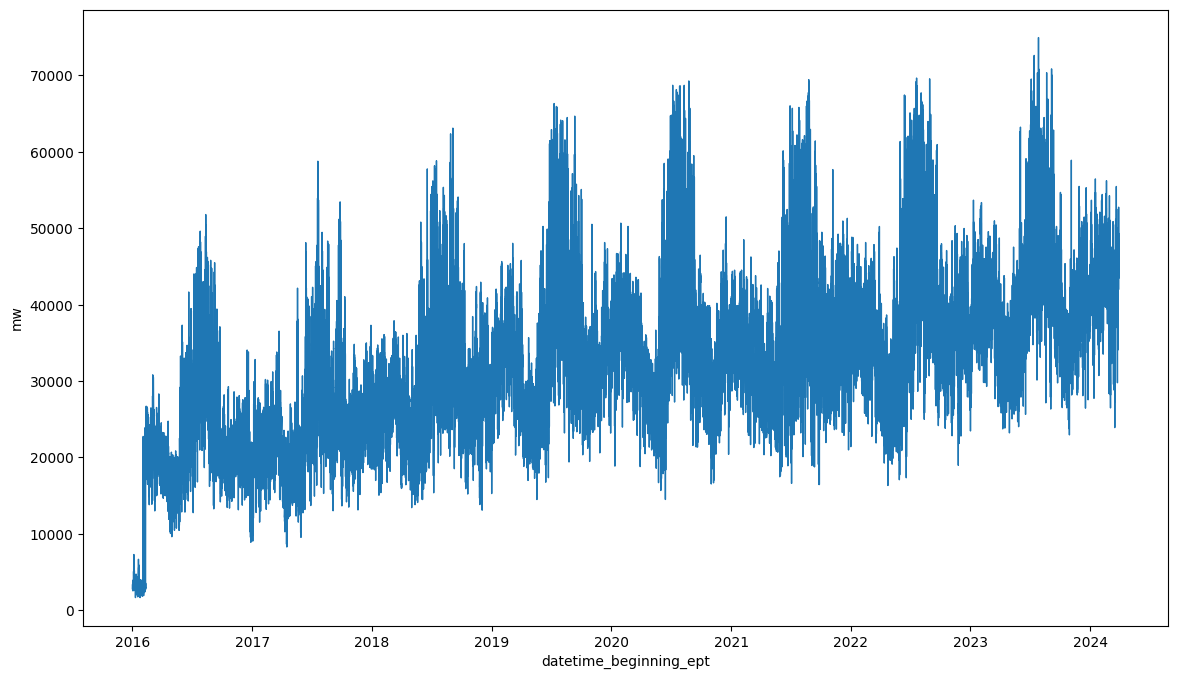

In [15]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

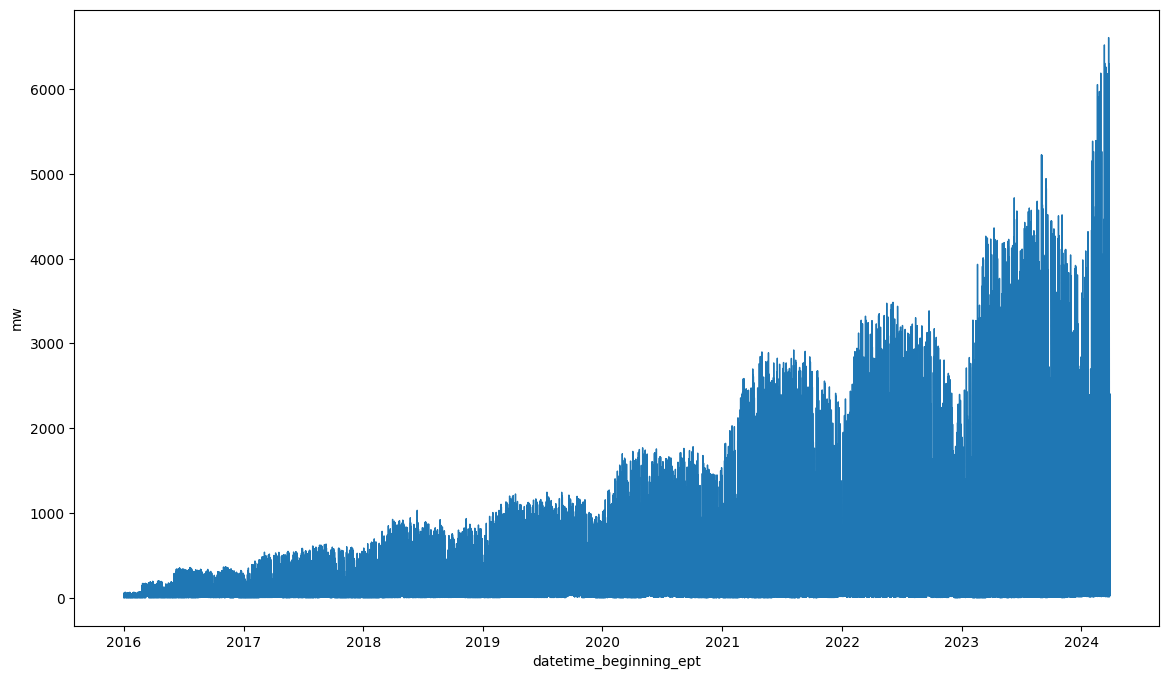

In [14]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Solar'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

In [123]:
print(gen_df['datetime_beginning_ept'].min())
print(gen_df['datetime_beginning_ept'].max())
print(load_df['datetime_beginning_ept'].min())
print(load_df['datetime_beginning_ept'].max())

2016-01-01 00:00:00
2024-03-28 23:00:00
1993-01-01 00:00:00
2024-03-27 23:00:00


In [26]:
from prophet import Prophet
df = pd.DataFrame({'ds' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['datetime_beginning_ept'],
                   'y' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['mw']})
m = Prophet()
m.fit(df)

14:17:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:01 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
future = m.make_future_dataframe(periods=365*2)
future.tail()

,ds
72811,2026-03-24 23:00:00
72812,2026-03-25 23:00:00
72813,2026-03-26 23:00:00
72814,2026-03-27 23:00:00
72815,2026-03-28 23:00:00


In [75]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
72811,2026-03-24 23:00:00,43858.316800,-7294.769911,98055.245407
72812,2026-03-25 23:00:00,43882.657178,-6360.440855,98962.142847
72813,2026-03-26 23:00:00,43271.392986,-6653.304596,96549.442863
72814,2026-03-27 23:00:00,41712.455949,-8326.402746,97228.881542
72815,2026-03-28 23:00:00,38005.122236,-12576.688174,91710.444824


/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


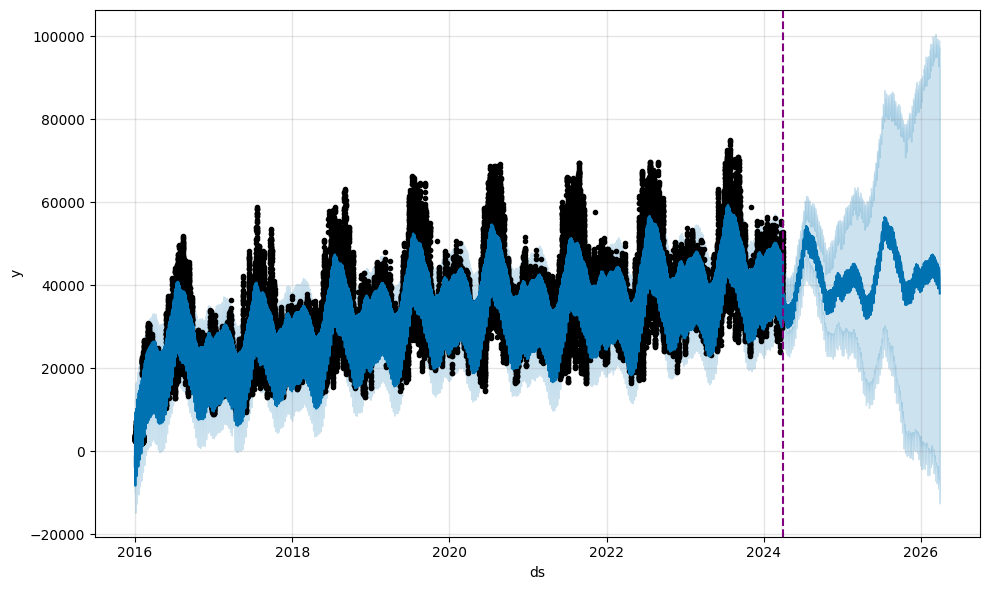

In [79]:
fig1 = m.plot(forecast)
ax = fig1.gca()
#ax.set_xlim(pd.to_datetime(['2020-01-01 00:00:00', '2025-03-28 23:00:00']))
plt.axvline(max(df['ds']), color = 'purple', ls = '--')


In [232]:
def prophetplot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='Time', ylabel='Megawatts (MW)',
    figsize=(10, 6), include_legend=False
):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.
    Returns
    -------
    A matplotlib figure.
    """
    user_provided_ax = False if ax is None else True
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds']#.dt.to_pydatetime()

    obs_t = fcst_t.loc[fcst_t < max(df['ds'])]
    obs_yhat = fcst['yhat'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_lower = fcst['yhat_lower'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_upper = fcst['yhat_upper'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    fc_t = fcst_t.loc[fcst_t >= max(df['ds'])]
    fc_yhat = fcst['yhat'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_lower = fcst['yhat_lower'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_upper = fcst['yhat_upper'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]

    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,
            label='Observed data points')
    ax.plot(obs_t, obs_yhat, ls='-', c='#005d5d', label='Forecast', lw = 0.75, alpha = 0.9)
    ax.plot(fc_t, fc_yhat, ls='-', c='#382238', label='Predict', lw = 0.75, alpha = 1)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(obs_t, obs_lower, obs_upper,
                        color='#009d9a', alpha=0.4, label='Uncertainty interval')
        ax.fill_between(fc_t, fc_lower, fc_upper,
                        color='#753f75', alpha=0.4, label='Uncertainty interval')
        # #755B69
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=0.75, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ### '#570408', '#005d5d'
    ax.set_xlim(pd.to_datetime(['2020-01-01 00:00:00', '2026-01-01 00:00:00']))
    ax.set_ylim(0, 90000)
    plt.axvline(max(df['ds']), color = 'black', ls = '--', lw = 1.2)
    

    if include_legend:
        ax.legend()
        plt.legend(loc = 'upper left')
    if not user_provided_ax:
        fig.tight_layout()
    return fig

from matplotlib.dates import AutoDateLocator, AutoDateFormatter

/var/folders/m8/939h_p3x6fq4_c0w_pfktz840000gn/T/ipykernel_3511/4274114557.py:41: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,


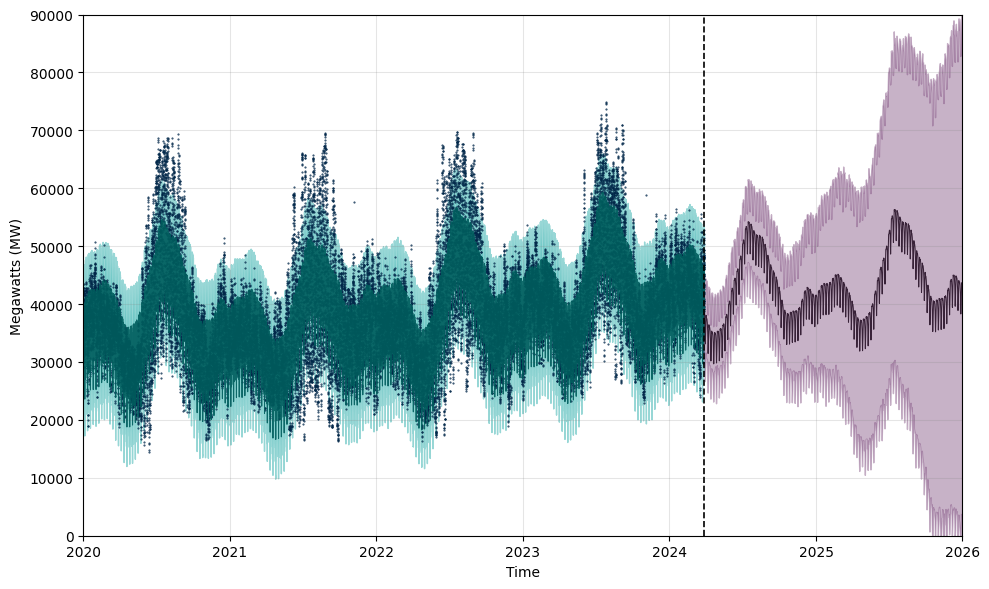

In [233]:
prophetplot(m, forecast)
plt.show()

In [205]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01 00:00:00,4049.514706,-7854.965938,5213.185822,4049.514706,4049.514706,-5372.663188,-5372.663188,-5372.663188,-4028.467400,...,1066.573750,1066.573750,1066.573750,-2410.769538,-2410.769538,-2410.769538,0.0,0.0,0.0,-1323.148482
1,2016-01-01 01:00:00,4058.506939,-8851.095089,3618.553602,4058.506939,4058.506939,-6796.438563,-6796.438563,-6796.438563,-5439.601902,...,1052.281796,1052.281796,1052.281796,-2409.118457,-2409.118457,-2409.118457,0.0,0.0,0.0,-2737.931623
2,2016-01-01 02:00:00,4067.499173,-9795.428214,2545.496634,4067.499173,4067.499173,-7691.506899,-7691.506899,-7691.506899,-6321.178337,...,1037.103962,1037.103962,1037.103962,-2407.432524,-2407.432524,-2407.432524,0.0,0.0,0.0,-3624.007726
3,2016-01-01 03:00:00,4076.491406,-9970.186976,2622.328321,4076.491406,4076.491406,-7993.053228,-7993.053228,-7993.053228,-6607.961798,...,1020.620385,1020.620385,1020.620385,-2405.711815,-2405.711815,-2405.711815,0.0,0.0,0.0,-3916.561821
4,2016-01-01 04:00:00,4085.483640,-9955.040346,3179.582334,4085.483640,4085.483640,-7557.502324,-7557.502324,-7557.502324,-6155.926136,...,1002.380221,1002.380221,1002.380221,-2403.956409,-2403.956409,-2403.956409,0.0,0.0,0.0,-3472.018684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72811,2026-03-24 23:00:00,47101.889079,-7294.769911,98055.245407,-2329.354221,101051.364380,-3243.572278,-3243.572278,-3243.572278,-2086.262201,...,1311.593261,1311.593261,1311.593261,-2468.903338,-2468.903338,-2468.903338,0.0,0.0,0.0,43858.316800
72812,2026-03-25 23:00:00,47107.834563,-6360.440855,98962.142847,-2384.983344,101234.039699,-3225.177386,-3225.177386,-3225.177386,-2086.262201,...,1508.716716,1508.716716,1508.716716,-2647.631901,-2647.631901,-2647.631901,0.0,0.0,0.0,43882.657178
72813,2026-03-26 23:00:00,47113.780048,-6653.304596,96549.442863,-2440.612466,101411.882346,-3842.387062,-3842.387062,-3842.387062,-2086.262201,...,1080.363947,1080.363947,1080.363947,-2836.488808,-2836.488808,-2836.488808,0.0,0.0,0.0,43271.392986
72814,2026-03-27 23:00:00,47119.725533,-8326.402746,97228.881542,-2496.241588,101589.724993,-5407.269583,-5407.269583,-5407.269583,-2086.262201,...,-285.531740,-285.531740,-285.531740,-3035.475642,-3035.475642,-3035.475642,0.0,0.0,0.0,41712.455949
